In [ ]:
# 빅콘테스트 2020

In [1]:
# 데이터 전처리, 시각화 라이브러리 import 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib
matplotlib.rcParams['font.family'].insert(0, 'Malgun Gothic') 

# 학습모델 및 평가 도구 import 
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
import  sklearn.metrics as mt
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import sklearn.model_selection as ms

# 0-1 전처리 라이브러리 import 
from sklearn.preprocessing import MinMaxScaler

# 인공신경망 모델 라이브러리 import 
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

Using TensorFlow backend.
D:\ringa\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ringa\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ringa\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ringa\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Pas

In [23]:
# 빅콘테스트 기본 제공 데이터(홈쇼핑 실적, 시청률) 불러오기
실적데이터1 = pd.read_excel('../01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터.xlsx', header=1)
평가데이터1 = pd.read_excel('../02_평가데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx', header=1)
시청률데이터1 = pd.read_excel('../01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx', header=1)

# 시청률데이터1 전처리

# 행과 열의 마지막 잘라내기 (평균 낸거 지우기)
시청률데이터1 = 시청률데이터1.iloc[:-1, :-1]

# 시간대 뒤에 ':00붙이기'  <- 성과데이터의 데이터화 규격 맞추기 위함.
시청률데이터1['시간대'] = 시청률데이터1['시간대'] + ':00'

# 시간대열 인덱스로 바꾸기
시청률데이터1.set_index('시간대', inplace=True)

# 외부데이터 강수량, 풍속, 기온 데이터
강수량1 = pd.read_csv('../01_제공데이터/강수량.csv', encoding='euc-kr')
풍속1 = pd.read_csv('../01_제공데이터/풍속.csv', encoding='euc-kr')
기온1 = pd.read_csv('../01_제공데이터/기온.csv', encoding='euc-kr')

# 강수량, 풍속, 기온 데이터에서 원하는 열만 선택하여 성과데이터에 합칠 준비
강수량 = 강수량1.sort_values(by = '일시')
풍속 = 풍속1.sort_values(by = '일시')
기온 = 기온1.sort_values(by = '일시')

풍속.일시=pd.to_datetime(풍속.일시).map(lambda x : str(x).split(" ")[0])

강수량 = 강수량[['일시', '평균일강수량(mm)']]
풍속 = 풍속[['일시', '최대풍속(m/s)']]
기온 = 기온[['일시', '평균최고기온(℃)', '평균최저기온(℃)']]

강수량.index = list(range(365))
풍속.index = list(range(365))
기온.index = list(range(365))

In [92]:
# 데이터 매번 불러오지 않기 위해 복사해서 저장
실적데이터 = 실적데이터1.copy()
시청률데이터 = 시청률데이터1.copy()
평가데이터 = 평가데이터1.copy()

# 컬럼명 변경 (노출(분) -> 노출만 변경)
실적데이터.columns = ['방송일시', '노출', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액']

# 결측치 제거 (취급액은 0으로, 노출은 위의 값으로 채움)
실적데이터.취급액 = 실적데이터.취급액.fillna(0)
실적데이터.노출 = 실적데이터.노출.fillna(method = 'ffill')

# 2020 데이터 지우기
실적데이터 = 실적데이터[:38300]

# 방송일시로부터 시간(월, 주, 요일, 일, 시간, ) 데이터 열로 추가
dt = datetime.datetime.now()

실적데이터['요일'] = 실적데이터['방송일시'].dt.dayofweek
실적데이터['월']  = 실적데이터['방송일시'].dt.month
실적데이터['주'] = 실적데이터['방송일시'].dt.week
실적데이터['시']  = 실적데이터['방송일시'].dt.hour
실적데이터['일'] = 실적데이터['방송일시'].dt.day
실적데이터['분'] = 실적데이터['방송일시'].dt.minute

실적데이터['방송시간'] = 실적데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[1][:])
실적데이터['일시'] = 실적데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[0])

최고시청률=[]
for i in range(len(실적데이터)):
    시작=실적데이터.방송시간.iloc[i]
    종료=str(pd.to_datetime(실적데이터.방송시간.iloc[i])+datetime.timedelta(minutes=round(float(실적데이터.노출.iloc[i]),0)-1)).split(" ")[1][:]
    최고시청률.append((시청률데이터[실적데이터.일시.iloc[i]].loc[시작:종료].max()))
    
실적데이터['분당최고시청률']=최고시청률

# 분당평균시청률 더 잘 보기(* 100)
실적데이터['분당최고시청률'] = round(실적데이터['분당최고시청률'] * 100, 3)

# 상품명 컬럼 삭제
#실적데이터.drop('상품명', axis=1, inplace=True)

# 주문량
실적데이터['주문량'] = (실적데이터.취급액 / 실적데이터.판매단가).fillna(0)

# 판매단가 단위 줄이기
실적데이터['판매단가'] = 실적데이터.판매단가 / 100000

# 상품코드 마더코드 사이즈 줄이기
실적데이터['상품코드'] = 실적데이터.상품코드 - 200000
실적데이터['마더코드'] = 실적데이터.마더코드 - 100000


# 실적데이터에 강수량 평균, 기온 평균 최고 기온/ 평균 최저 기온, 최대 풍속 추가
실적데이터 = pd.merge(실적데이터, 강수량, on='일시' )
실적데이터 = pd.merge(실적데이터, 기온, on='일시')
실적데이터 = pd.merge(실적데이터, 풍속, on='일시')

D:\ringa\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [225]:
# NS홈쇼핑 주가 데이터 이용
# 2019년 00월 00일 리스트 생성
a = []
for i in range(13):
    if i in [1, 3, 5, 7, 8, 10, 12]:
        for j in range(1, 32):
            if i < 10:
                s1 = '0'+ str(i)
            else:
                s1 = str(i)
            if j < 10:
                s2 = '0'+ str(j)
            else:
                s2 = str(j)
            a.append("2019년 {}월 {}일".format(s1, s2))
    elif i in [4, 6, 9, 11]:
        for j in range(1, 31):
            if i < 10:
                s1 = '0'+ str(i) 
            else:
                s1 = str(i)
            if j < 10:
                s2 = '0'+ str(j)
            else:
                s2 = str(j)
            a.append("2019년 {}월 {}일".format(s1, s2))
    elif i == 2:
        for j in range(1, 29):
            if i < 10:
                s1 = '0'+ str(i) 
            else:
                s1 = str(i)
            if j < 10:
                s2 = '0'+ str(j)
            else:
                s2 = str(j)
            a.append("2019년 {}월 {}일".format(s1, s2))
        
a = pd.DataFrame(a)
a.columns = ['날짜']
a

# 주가데이터 불러오기
주가데이터 = pd.read_csv('../01_제공데이터/주가데이터.csv')
주가데이터 = 주가데이터.sort_values(by = '날짜')

# 주가데이터의 빈 날짜를 a 리스트와 merge를 통해 채움
# 날짜 위에서 아래로 1월 1일 ~ 12월 31일
주가데이터2 = pd.merge(주가데이터, a, on='날짜', how='outer')
주가데이터2 = 주가데이터2.sort_values(by='날짜')

# 주가데이터 빈 행은 위아래 행으로 채움
주가데이터2 = 주가데이터2.fillna(method = 'ffill')
주가데이터2 = 주가데이터2.fillna(method = 'bfill')

# 거래량 K 지우고 1000해서 구함
주가데이터2.거래량=주가데이터2.거래량.map(lambda x : x[:-1])
주가데이터2.거래량=pd.to_numeric(주가데이터2.거래량)
주가데이터2.거래량=주가데이터2.거래량*1000

temp = pd.concat([실적데이터.pivot_table(index=['월','일'], values='주문량', aggfunc='mean').reset_index(), 주가데이터2.종가], axis=1)
temp.종가 = pd.to_numeric(temp.종가.map(lambda X: X.replace(",","")))
temp.drop(['주문량'], axis=1, inplace=True)
실적데이터 = pd.merge(실적데이터, temp, on=['월', '일'], how='outer')

,날짜
0,2019년 01월 01일
1,2019년 01월 02일
2,2019년 01월 03일
3,2019년 01월 04일
4,2019년 01월 05일
...,...
360,2019년 12월 27일
361,2019년 12월 28일
362,2019년 12월 29일
363,2019년 12월 30일


In [93]:
# 브랜드 열

# 상품명에서 불필요한 단어 제거
list1 = []
for item in 실적데이터[['상품명']].values:
    for i in ['(직매입)', '일시불', '무이자', '도냄', 'a4', '뉴', '(일)', '(무)', '특집', '(쿠)',
              '초특가''(세일20%)', '1세트', '2세트', '(더블+더블)', '(더블+싱글)', '(더블사이즈)', 
              '(싱글사이즈)', '(점보특대형)', '(점보형)', '(중형)', '(퀸+퀸)', '(퀸+싱글)', '(싱글+싱글)', 
              '(킹사이즈)', '(퀸사이즈)', '[완벽더블]', '파격가', '초특가', '무)', '(렌탈)', '국내산']:
        item[0] = item[0].replace(i, "")
    list1.append(item[0].strip())

# 숫자, 영어, 한글을 제외한 문자, 공백 제거
list2 = []
for i in list1:
    result_string = ""
    for c in i:
        if c == " ":
            result_string += c
        elif c.isalnum():
            result_string += c
    list2.append(result_string.strip())
    
# 브랜드명이 첫 어절에 온다고 판단, 첫 어절로 브랜드 컬럼 생성
list3 = []
for item in list2:
    list3.append(item.split(" ")[0])
실적데이터['브랜드'] = list3

# 브랜드별 가중치 부여
# 브랜드별 평균 주문량 계산
df_temp = 실적데이터.pivot_table(
    index='브랜드', values='주문량', aggfunc='count').sort_values(by='주문량', ascending=False)

# MinMaxScaler로 0~1 사이값으로 scale 조정
df_temp1 = pd.DataFrame(
    MinMaxScaler().fit_transform(df_temp), index=df_temp.index)

# 브랜드별 평균 주문량의 scale 조절값 = 브랜드 점수. 브랜드 컬럼 생성
df_temp1 = df_temp1.reset_index()
실적데이터 = pd.merge(실적데이터, df_temp1, on='브랜드')
실적데이터.rename({0: '브랜드점수'}, axis=1, inplace=True)


In [94]:
# ---------------------------------------------- 파생변수 생성 후 필요없는 칼럼 삭제 ------------------------------------------------------------
# 수목금토 / 일월화 칼럼 추가
# 실적데이터['수목금토'] = 실적데이터.요일.map(lambda X: X in [3,4,5,6]).map(lambda X: 1 if X else 0)
실적데이터['주중주말'] = 실적데이터.요일.map(lambda X: X in [5, 6]).map(lambda X: 1 if X else 0)

# 7,8,9월의 다른 추세 확인 후 칼럼 생성
# 실적데이터['월789'] = 실적데이터.월.map(lambda X: X in [7, 8, 9]).map(lambda X: 1 if X else 0)

# 6-10월
# 실적데이터['월610'] = 실적데이터.월.map(lambda X: X in [6,7,8,9,10]).map(lambda X: 1 if X else 0)
# 11-12월
# 실적데이터['월1112'] = 실적데이터.월.map(lambda X: X in [11,12]).map(lambda X: 1 if X else 0)

# 상,하반기 구분
# 실적데이터['상반기'] = 실적데이터.월.map(lambda X: X in [1,2,3,4,5,6]).map(lambda X: 1 if X else 0)

# 계절 구분
# 실적데이터['봄'] = 실적데이터.월.map(lambda X: X in [3,4,5]).map(lambda X: 1 if X else 0)
# 실적데이터['여름'] = 실적데이터.월.map(lambda X: X in [6,7,8]).map(lambda X: 1 if X else 0)
# 실적데이터['가을'] = 실적데이터.월.map(lambda X: X in [9,10,11]).map(lambda X: 1 if X else 0)
# 실적데이터['겨울'] = 실적데이터.월.map(lambda X: X in [12,1,2]).map(lambda X: 1 if X else 0)


# 일 : 월초,말이랑 중간 비교 / 의미없음
# 실적데이터['월말초'] = 실적데이터.일.map(lambda X: X in [1,2,3,4,5,6,27,28,29,30,31]).map(lambda X: 1 if X else 0)

# 판매단가 분포에 따른 분류
# 실적데이터['저가'] = 실적데이터.판매단가.map(lambda X: 1 if X <=30000 else 0)
# 실적데이터['중가'] = 실적데이터.판매단가.map(lambda X: 1 if 30000< X <= 400000  else 0)
# 실적데이터['고가'] = 실적데이터.판매단가.map(lambda X: 1 if X >400000  else 0)

# 노출 시간 
# 실적데이터['노출20미만'] = 실적데이터.노출.map(lambda X: 1 if X < 20  else 0)
# 실적데이터['노출2030'] = 실적데이터.노출.map(lambda X: 1 if 20 <= X < 30  else 0)
# 실적데이터['노출30이상'] = 실적데이터.노출.map(lambda X: 1 if X >= 30  else 0)

# 32주 기준으로 다른 추세 확인
# 실적데이터['주32후'] = 실적데이터.주.map(lambda X: 1 if X >= 32  else 0)

# 시간별 상품코드 배치 
# 실적데이터['시간1015사이20이후'] = 실적데이터.시.map(lambda X: 1 if X >= 20 or 10 < X < 15  else 0)
# 실적데이터['시간789사이1518'] = 실적데이터.시.map(lambda X: 1 if 15 < X < 18 or 6<X<10  else 0)
# 실적데이터['저녁'] = 실적데이터.시.map(lambda X: 1 if 18 < X <= 23  else 0)
# 실적데이터['새벽'] = 실적데이터.시.map(lambda X: 1 if 5 < X < 12  else 0)
# 실적데이터['낮'] = 실적데이터.시.map(lambda X: 1 if 11 < X < 20  else 0)

# 168개로 나누기
# 실적데이터['168시간기준']=실적데이터.방송일시.dt.weekday*24+실적데이터.방송일시.dt.hour

# 실적데이터['시간6-9'] = 실적데이터.노출.map(lambda X: 1 if 6 < X < 21  else 0)

# 실적데이터['시간15-17'] = 실적데이터.노출.map(lambda X: 1 if 14 < X < 18  else 0)

# 방송시간 3시간 별로 분류
# 시간대 = []
# for i in range(len(실적데이터['방송시간'])):
#     time = int(실적데이터['방송시간'][i][:2])
#     if time>=0 and time<3:
#         시간대.append('새벽1')
#     if time>=3 and time<6:
#         시간대.append('새벽2')    
#     if time>=6 and time<9:
#         시간대.append('오전1')
#     if time>=9 and time<12:
#         시간대.append('오전2')
#     if time>=12 and time<15:
#         시간대.append('오후1')
#     if time>=15 and time<18:
#         시간대.append('오후2')
#     if time>=18 and time<21:
#         시간대.append('저녁1')
#     if time>=21 and time<24:
#         시간대.append('저녁2')
        
# 실적데이터['시간대'] = 시간대

# 계산할 수 없는 칼럼 삭제
실적데이터.drop(['방송일시', '상품명', '방송시간', '일시', '브랜드'], axis=1, inplace=True)

In [96]:
#-------------------------------------------통째로 칼럼화---------------------------------------------------------
# 요일 칼럼화
# 요일_0 ~ 요일_6
실적데이터 = pd.concat([실적데이터, pd.get_dummies(실적데이터.요일, prefix='요일')], axis=1)
실적데이터.drop('요일', axis=1, inplace=True)

# 월 칼럼화
# 1 ~ 12 -> 월_1, 월_2, ~ ,월_12
실적데이터 = pd.concat([실적데이터, pd.get_dummies(실적데이터.월, prefix='월')], axis=1)
실적데이터.drop('월', axis=1, inplace=True)

# 일 칼럼화
# 1 ~ 31 -> 일_1, 일_2, ~, 일_31
실적데이터 = pd.concat([실적데이터, pd.get_dummies(실적데이터.일, prefix='일')], axis=1)
실적데이터.drop('일', axis=1, inplace=True)

# 시 칼럼화
# 1 ~ 23 -> 시_1, 시_2, ~, 시_23
실적데이터 = pd.concat([실적데이터, pd.get_dummies(실적데이터.시, prefix='시')], axis=1)
실적데이터.drop('시', axis=1, inplace=True)

# 없는 분 만들기
분_df=pd.get_dummies(실적데이터.분)
분=[]
분1=['분_'+ str(i) for i in range(0,60,5)]
for i in 분_df.columns:
    분.append('분_' + str(i))
분_df.columns=분
for i in [item for item in 분1 if item not in 분]:
    분_df[i]=[0 for i in range(len(실적데이터))]
분_df=분_df[분1]
실적데이터=pd.concat([실적데이터, 분_df],axis=1)

# 분 칼럼화
# 1 ~ 60 -> 분_1, 분_2, ~, 분_60
# 실적데이터 = pd.concat([실적데이터, pd.get_dummies(실적데이터.분, prefix='분')], axis=1)
실적데이터.drop('분', axis=1, inplace=True)

# 주 칼럼화
# 1 ~ 52 -> 주_1, 주_2, ~, 주_52
실적데이터 = pd.concat([실적데이터, pd.get_dummies(실적데이터.주, prefix='주')], axis=1)
실적데이터.drop('주', axis=1, inplace=True)

#168 넘기기
#'168시간기준'
# 실적데이터 = pd.concat([실적데이터, pd.get_dummies(실적데이터['168시간기준'], prefix='168시간기준')], axis=1)
# 실적데이터.drop('168시간기준', axis=1, inplace=True)

# 상품군 컬럼화
# ['가구', '가전', '건강기능', '농수축', '무형', '생활용품', '속옷', '의류', '이미용', '잡화','주방', '침구']
실적데이터 = pd.concat([실적데이터, pd.get_dummies(실적데이터.상품군)], axis=1)
실적데이터.drop('상품군', axis=1, inplace=True)

# 시간대(3시간 단위) 컬럼화
# 실적데이터 = pd.concat([실적데이터, pd.get_dummies(실적데이터.시간대)], axis=1)
# 실적데이터.drop('시간대', axis=1, inplace=True)

# 상품코드 칼럼화
# 1 ~ 52 -> 상품코드_1, 상품코드_2, ~, 상품코드_??
#실적데이터 = pd.concat([실적데이터, pd.get_dummies(실적데이터.상품코드, prefix='상품코드')], axis=1)
#실적데이터.drop('상품코드', axis=1, inplace=True)

# 마더코드 칼럼화
# 1 ~ 52 -> 상품코드_1, 상품코드_2, ~, 상품코드_??
#실적데이터 = pd.concat([실적데이터, pd.get_dummies(실적데이터.마더코드, prefix='상품코드')], axis=1)
#실적데이터.drop('마더코드', axis=1, inplace=True)

# ---------------------------------------- 없는 요일 월 등 칼럼 추가 ----------------------------------------------
# 월_df=pd.get_dummies(실적데이터.월)
# 월=[]
# 월1=['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']
# for i in 월_df.columns:
#     월.append(str(i)+'월')
# 월_df.columns=월 
# for i in [item for item in 월 if item not in 월1]:
#     월_df[i]=[0 for i in range(38300)]
# 실적데이터=pd.concat([실적데이터, 월_df],axis=1)


# 정규화 (선택)

In [ ]:
# z정규화(표준편차를 이용해서 이상치의 영향을 덜 받는 정규화)

def z_score_normalize(lst):
    normalized = []
    for value in lst:
        normalized_num = (value - np.mean(lst)) / np.std(lst)
        normalized.append(normalized_num)
    return normalized


# 기존 데이터프레임 전처리
X_features = 실적데이터.drop('취급액', axis=1)
for i in X_features.columns:
    X_features[i] = z_score_normalize(X_features[i])
    
X_train, X_test, y_train, y_test = \
train_test_split(X_features, y_target ,test_size=0.3, random_state=0)

In [ ]:
# 0~1 정규화
minmaxScaler = MinMaxScaler()
X_features = minmaxScaler.fit_transform(X_features)
y_target = minmaxScaler.fit_transform(np.array(y_target).reshape(-1,1))
X_features

# Data Split

In [124]:
# 파생변수 고르기 위한 drop 변경
# 독립변수 = 취급액, 분당평균시청률, 주문량 제외하고 전부
# 종속변수 = 주문량
실적데이터_test = 실적데이터
X_features = 실적데이터_test.drop(['취급액','주문량', '분당최고시청률','평균일강수량(mm)', '평균최고기온(℃)', '평균최저기온(℃)','최대풍속(m/s)'], axis=1)
y_target = 실적데이터_test.주문량

# train test split
X_train, X_test, y_train, y_test = \
train_test_split(X_features, y_target ,test_size=0.3, random_state=0)

In [ ]:
# raw data 기간별로 split 해보기
#len(실적데이터) * 0.7
X = 실적데이터[:26810]
y = 실적데이터[26810:]

# X_features = X.drop(['취급액','주문량','마더코드', '상품코드'], axis=1)
# y_target = X.주문량

# X_test  = y_target.drop(['취급액','주문량','마더코드', '상품코드'], axis=1)
# y_test = y_target.주문량

# K Fold

In [ ]:
kfold = ms.KFold(5, shuffle=True, random_state=0)

n_iter = 0
r2_scores = []

for train_num, test_num in kfold.split(X):
    X_train, X_test = X.iloc[train_num], X.iloc[test_num]
    y_train, y_test = y.iloc[train_num], y.iloc[test_num]
    
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_test)
    
    n_iter += 1
    r2_scores.append(mt.r2_score(y_test, y_pred))

In [ ]:
# data를 랜덤으로 찢었을 때
for i in range(n_iter):
    print(r2_scores[i])
print('평균: ', np.round(np.mean(r2_scores), 3))

# XGBoost 

In [252]:
xgb_reg = XGBRegressor(n_estimators=500, gamma=1, learning_rate=0.1, max_depth=15, n_jobs=-1,
                       min_child_weight=5, random_state=1)

xgb_reg.fit(X_train, y_train) # early_stopping_rounds=200,
         # eval_set = [(X_test, y_test)], eval_metric='logloss')

In [125]:
xgb_reg.score(X_test, y_test)

0.8744919685063357

# LGBMRegressor

In [303]:
# conda install lightgbm
lgbm_reg = LGBMRegressor()

num = len(X_train.columns) # len 뽑아서 열을 숫자 형태로 바꿔줘야 모델 학습 가능

# 위에서 뽑은 길이대로 숫자 리스트 만들어서 train 데이터 열 형태를 모두 수치화 후 학습
# 열 확인 위해서는 데이터 다시 가져와야 함
cols = []
for i in range(num):
        cols.append(str(i))
X_train.columns = cols

lgbm_reg.fit(X_train, y_train)
y_pred = lgbm_reg.predict(X_test)
mt.r2_score(y_test, y_pred)

0.815747113908251

# AdaBoost

In [ ]:
ada_reg = AdaBoostRegressor(base_estimator=None, learning_rate=0.05, loss='exponential',
         n_estimators=100, random_state=0) 

ada_reg.fit(X_train, y_train)

y_pred = ada_reg.predict(X_test)

mt.r2_score(y_test, y_pred)

# KNN

In [ ]:
knn_reg = KNeighborsRegressor(n_neighbors = 12, weights = "distance")
knn_reg.fit(X_train, y_train)

y_pred = knn_reg.predict(X_test)

mt.r2_score(y_test, y_pred)

# 심층신경망

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y)

# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[11]),
#     keras.layers.Dense(300, kernel_initializer="he_normal"),
#     keras.layers.LeakyReLU(),
#     keras.layers.Dense(100),
#     keras.layers.LeakyReLU(),
#     keras.layers.Dense(1, activation="softmax")
# ])
n=X_train.shape[1:]
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=n, kernel_initializer='normal'),
    keras.layers.Dense(32, activation='relu', kernel_initializer='normal'),
    keras.layers.Dense(1)
])

# model = tf.keras.models.Sequential()
# model.add(tf.keras.Input(shape=X_train.shape[1:]))
# model.add(tf.keras.layers.Dense(32, activation='relu'))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse', metrics=['mae'])


model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=10, validation_split=0.2, verbose=1)
# test_mse_score, test_mae_score = model.evaluate(X_test, y_test)
loss_and_metrics = model.evaluate(X_test, y_test)
print(f'\nLoss : {loss_and_metrics[0]:6}')
print(f'mae : {loss_and_metrics[1]:6}')

In [ ]:
y_pred=model.predict(X_test)
mt.r2_score(y_test, y_pred)

# 하이퍼 파라미터 조정

In [9]:
from sklearn.model_selection import GridSearchCV

xgb_param = {
    'subsample': [0.4, 0.6],                   #  2
    'min_child_weight':[1, 5, 10],             #  3
    'gamma':[0.5, 1, 1.5, 2, 5],               #  4
    'max_depth':[4,10,15],                     #  3
    'eta':[0.05, 0.01,  0.1, 0.3]              #  4
}
xgb = XGBRegressor()
grid_xgb = GridSearchCV(xgb, param_grid=xgb_param, scoring='r2', cv=5)
grid_xgb.fit(X_train, y_train)

print('final params', grid_xgb.best_params_)   # 최적의 파라미터 값 출력
print('best score', grid_xgb.best_score_)      # 최고의 점수

# final params {'eta': 0.1, 'gamma': 1, 'max_depth': 15, 'min_child_weight': 5, 'subsample': 0.6}
#  best score 0.8600565191649612

# 평가데이터 취급액 예측

In [126]:
평가데이터 = 평가데이터1.copy()

# 컬럼명 변경 (노출(분) -> 노출만 변경)
평가데이터.columns = ['방송일시', '노출', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액']

# 결측치 제거 (취급액은 0으로, 노출은 위의 값으로 채움)
평가데이터.취급액 = 평가데이터.취급액.fillna(0)
평가데이터.노출 = 평가데이터.노출.fillna(method = 'ffill')

# 방송일시로부터 시간(월, 주, 요일, 일, 시간, ) 데이터 열로 추가
dt = datetime.datetime.now()

평가데이터['요일'] = 평가데이터['방송일시'].dt.dayofweek
평가데이터['월']  = 평가데이터['방송일시'].dt.month
평가데이터['주'] = 평가데이터['방송일시'].dt.week
평가데이터['시']  = 평가데이터['방송일시'].dt.hour
평가데이터['일'] = 평가데이터['방송일시'].dt.day
평가데이터['분'] = 평가데이터['방송일시'].dt.minute

평가데이터['방송시간'] = 평가데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[1][:])
평가데이터['일시'] = 평가데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[0])


# 상품명 컬럼 삭제
#평가데이터.drop('상품명', axis=1, inplace=True)


# 판매단가 단위 줄이기
평가데이터['판매단가'] = 평가데이터.판매단가 / 100000

# 상품코드 마더코드 사이즈 줄이기
평가데이터['상품코드'] = 평가데이터.상품코드 - 200000
평가데이터['마더코드'] = 평가데이터.마더코드 - 100000

D:\ringa\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app


In [127]:
# 브랜드 열

# 상품명에서 불필요한 단어 제거
list1 = []
for item in 평가데이터[['상품명']].values:
    for i in ['(직매입)', '일시불', '무이자', '도냄', 'a4', '뉴', '(일)', '(무)', '특집', '(쿠)',
              '초특가''(세일20%)', '1세트', '2세트', '(더블+더블)', '(더블+싱글)', '(더블사이즈)', 
              '(싱글사이즈)', '(점보특대형)', '(점보형)', '(중형)', '(퀸+퀸)', '(퀸+싱글)', '(싱글+싱글)', 
              '(킹사이즈)', '(퀸사이즈)', '[완벽더블]', '파격가', '초특가', '무)', '(렌탈)', '국내산']:
        item[0] = item[0].replace(i, "")
    list1.append(item[0].strip())

# 숫자, 영어, 한글을 제외한 문자, 공백 제거
list2 = []
for i in list1:
    result_string = ""
    for c in i:
        if c == " ":
            result_string += c
        elif c.isalnum():
            result_string += c
    list2.append(result_string.strip())
    
# 브랜드명이 첫 어절에 온다고 판단, 첫 어절로 브랜드 컬럼 생성
list3 = []
for item in list2:
    list3.append(item.split(" ")[0])
평가데이터['브랜드'] = list3

# 브랜드별 가중치 부여
# 브랜드별 평균 주문량 계산
df_temp = 평가데이터.pivot_table(
    index='브랜드', values='마더코드', aggfunc='count')

In [129]:
# MinMaxScaler로 0~1 사이값으로 scale 조정
df_temp1 = pd.DataFrame(
    MinMaxScaler().fit_transform(df_temp), index=df_temp.index)

# 브랜드별 평균 주문량의 scale 조절값 = 브랜드 점수. 브랜드 컬럼 생성
df_temp1 = df_temp1.reset_index()
평가데이터 = pd.merge(평가데이터, df_temp1, on='브랜드')
평가데이터.rename({0: '브랜드점수'}, axis=1, inplace=True)

평가데이터['주중주말'] = 평가데이터.요일.map(lambda X: X in [5, 6]).map(lambda X: 1 if X else 0)

# 계산할 수 없는 칼럼 삭제
평가데이터.drop(['방송일시', '상품명', '방송시간', '일시', '브랜드'], axis=1, inplace=True)

#-------------------------------------------통째로 칼럼화---------------------------------------------------------
# 요일 칼럼화
# 요일_0 ~ 요일_6
평가데이터 = pd.concat([평가데이터, pd.get_dummies(평가데이터.요일, prefix='요일')], axis=1)
평가데이터.drop('요일', axis=1, inplace=True)

# 주월분 없는거 만들기
월_df=pd.get_dummies(평가데이터.월)
월=[]
월1=['월_'+ str(i) for i in range(1,13)]
for i in 월_df.columns:
    월.append('월_' + str(i))
월_df.columns=월
for i in [item for item in 월1 if item not in 월]:
    월_df[i]=[0 for i in range(len(평가데이터))]
월_df=월_df[월1]
평가데이터=pd.concat([평가데이터, 월_df],axis=1)

일_df=pd.get_dummies(평가데이터.일)
일=[]
일1=['일_' + str(i) for i in range(1,32)]
for i in 일_df.columns:
    일.append('일_' + str(i))
일_df.columns=일
for i in [item for item in 일1 if item not in 일]:
    일_df[i]=[0 for i in range(len(평가데이터))]
일_df=일_df[일1]
평가데이터=pd.concat([평가데이터, 일_df],axis=1)

# 시 칼럼화
# 1 ~ 23 -> 시_1, 시_2, ~, 시_23
평가데이터 = pd.concat([평가데이터, pd.get_dummies(평가데이터.시, prefix='시')], axis=1)
평가데이터.drop('시', axis=1, inplace=True)

분_df=pd.get_dummies(평가데이터.분)
분=[]
분1=['분_'+ str(i) for i in range(0,60,5)]
for i in 분_df.columns:
    분.append('분_' + str(i))
분_df.columns=분
for i in [item for item in 분1 if item not in 분]:
    분_df[i]=[0 for i in range(len(평가데이터))]
분_df=분_df[분1]
평가데이터=pd.concat([평가데이터, 분_df],axis=1)

주_df=pd.get_dummies(평가데이터.주)
주=[]
주1=['주_'+ str(i) for i in range(1,53)]
for i in 주_df.columns:
    주.append('주_' + str(i))
주_df.columns=주
for i in [item for item in 주1 if item not in 주]:
    주_df[i]=[0 for i in range(len(평가데이터))]
주_df=주_df[주1]
평가데이터=pd.concat([평가데이터, 주_df],axis=1)

# # 월 칼럼화
# # 1 ~ 12 -> 월_1, 월_2, ~ ,월_12
# 평가데이터 = pd.concat([평가데이터, pd.get_dummies(평가데이터.월, prefix='월')], axis=1)
평가데이터.drop('월', axis=1, inplace=True)

# 일 칼럼화
# 1 ~ 31 -> 일_1, 일_2, ~, 일_31
# 평가데이터 = pd.concat([평가데이터, pd.get_dummies(평가데이터.일, prefix='일')], axis=1)
평가데이터.drop('일', axis=1, inplace=True)



# # 분 칼럼화
# # 1 ~ 60 -> 분_1, 분_2, ~, 분_60
# 평가데이터 = pd.concat([평가데이터, pd.get_dummies(평가데이터.분, prefix='분')], axis=1)
평가데이터.drop('분', axis=1, inplace=True)

# # 주 칼럼화
# # 1 ~ 52 -> 주_1, 주_2, ~, 주_52
# 평가데이터 = pd.concat([평가데이터, pd.get_dummies(평가데이터.주, prefix='주')], axis=1)
평가데이터.drop('주', axis=1, inplace=True)

#168 넘기기
#'168시간기준'
# 평가데이터 = pd.concat([평가데이터, pd.get_dummies(평가데이터['168시간기준'], prefix='168시간기준')], axis=1)
# 평가데이터.drop('168시간기준', axis=1, inplace=True)

# 상품군 컬럼화
# ['가구', '가전', '건강기능', '농수축', '무형', '생활용품', '속옷', '의류', '이미용', '잡화','주방', '침구']
평가데이터 = pd.concat([평가데이터, pd.get_dummies(평가데이터.상품군)], axis=1)
평가데이터.drop('상품군', axis=1, inplace=True)

# 시간대(3시간 단위) 컬럼화
# 평가데이터 = pd.concat([평가데이터, pd.get_dummies(평가데이터.시간대)], axis=1)
# 평가데이터.drop('시간대', axis=1, inplace=True)

# 상품코드 칼럼화
# 1 ~ 52 -> 상품코드_1, 상품코드_2, ~, 상품코드_??
#평가데이터 = pd.concat([평가데이터, pd.get_dummies(평가데이터.상품코드, prefix='상품코드')], axis=1)
#평가데이터.drop('상품코드', axis=1, inplace=True)

# 마더코드 칼럼화
# 1 ~ 52 -> 상품코드_1, 상품코드_2, ~, 상품코드_??
#평가데이터 = pd.concat([평가데이터, pd.get_dummies(평가데이터.마더코드, prefix='상품코드')], axis=1)
#평가데이터.drop('마더코드', axis=1, inplace=True)

# ---------------------------------------- 없는 요일 월 등 칼럼 추가 ----------------------------------------------
# 월_df=pd.get_dummies(평가데이터.월)
# 월=[]
# 월1=['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']
# for i in 월_df.columns:
#     월.append(str(i)+'월')
# 월_df.columns=월 
# for i in [item for item in 월 if item not in 월1]:
#     월_df[i]=[0 for i in range(38300)]
# 평가데이터=pd.concat([평가데이터, 월_df],axis=1)

평가데이터.drop(['취급액'], axis=1, inplace=True)

In [159]:
# 평가데이터 취급액 예측
result = xgb_reg.predict(평가데이터)
판매단가 = 평가데이터.판매단가 * 100000
result = 판매단가 * result
평가데이터1  = pd.concat([평가데이터1, result], axis=1)
평가데이터1.drop('취급액', axis=1, inplace=True)
평가데이터1.columns = ['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '예상취급액']

# 방송일시로부터 시간(월, 주, 요일, 일, 시간, ) 데이터 열로 추가
dt = datetime.datetime.now()

평가데이터1['요일'] = 평가데이터1['방송일시'].dt.dayofweek
평가데이터1['월']  = 평가데이터1['방송일시'].dt.month
평가데이터1['주'] = 평가데이터1['방송일시'].dt.week
평가데이터1['시']  = 평가데이터1['방송일시'].dt.hour
평가데이터1['일'] = 평가데이터1['방송일시'].dt.day
평가데이터1['분'] = 평가데이터1['방송일시'].dt.minute

평가데이터1['방송시간'] = 평가데이터1.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[1][:])
평가데이터1['일시'] = 평가데이터1.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[0])

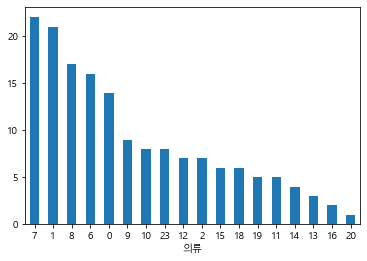

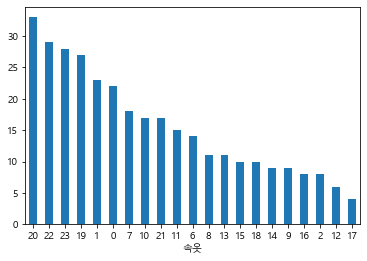

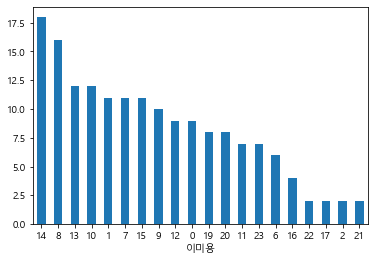

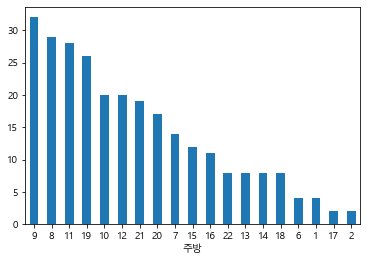

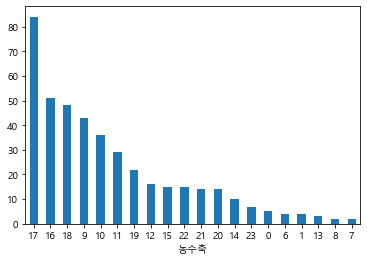

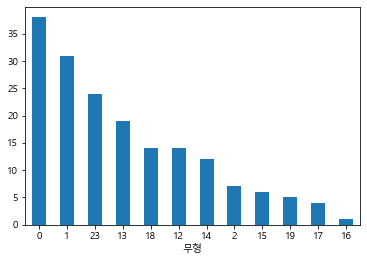

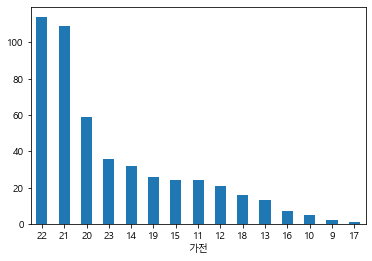

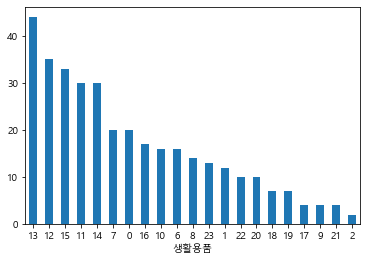

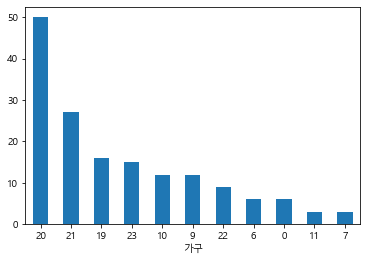

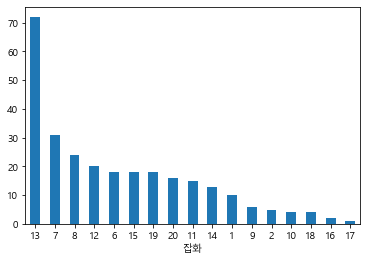

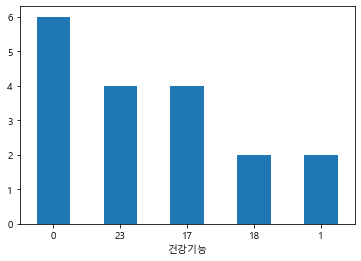

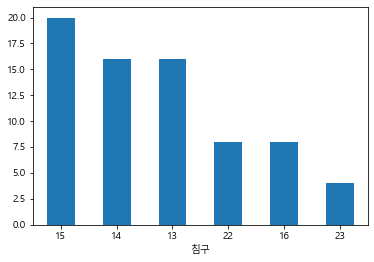

In [244]:
# 상품군 시간별 예상취급액 그래프
ratio25 = int(len(평가데이터) * 0.25)
for item in 평가데이터1.상품군.unique():
    plt.figure()
    평가데이터1[평가데이터1.상품군 == item].sort_values(by='예상취급액', ascending=False).시[:ratio25].value_counts().plot(kind='bar')
    plt.xticks(rotation=0)
    plt.xlabel(item)
    #plt.savefig('{}시간.png'.format(item))

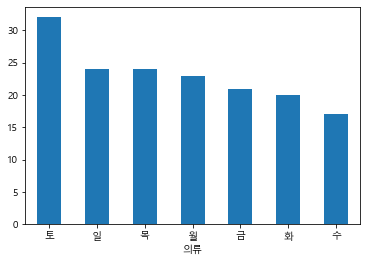

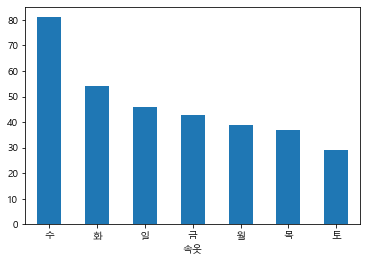

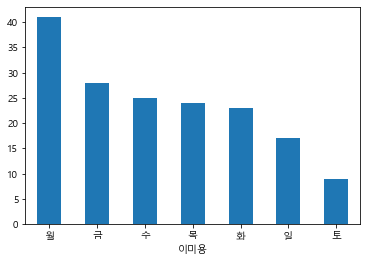

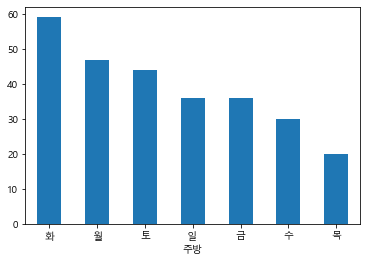

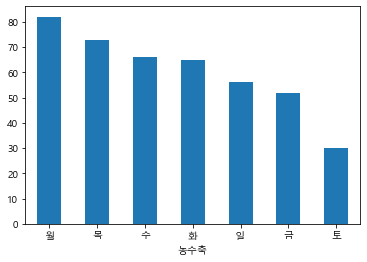

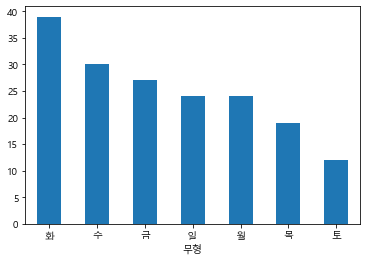

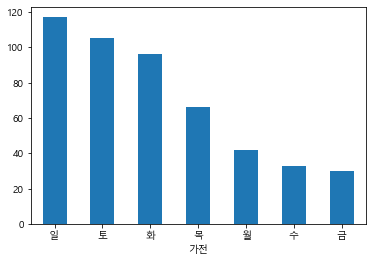

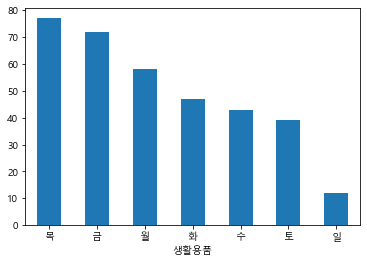

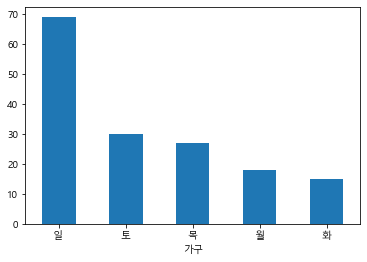

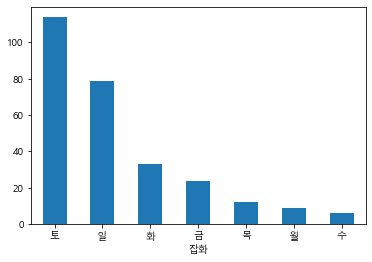

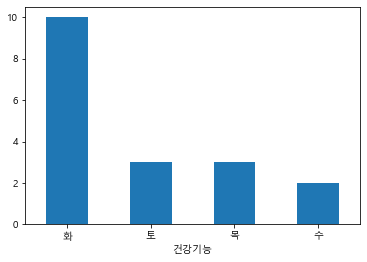

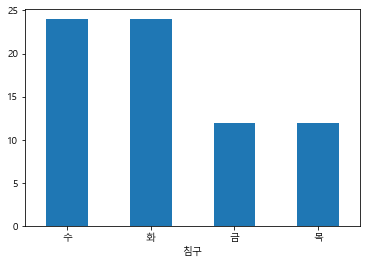

In [251]:
# 상품군 요일별 예상취급액 그래프
ratio25 = int(len(평가데이터) * 0.25)
for item in 평가데이터1.상품군.unique():
    plt.figure()
    temp = 평가데이터1[평가데이터1.상품군 == item].sort_values(by='예상취급액', ascending=False).요일[:ratio25].value_counts()
    temp.rename({0:'월',1:'화',2:'수',3:'목',4:'금',5:'토',6:'일'},axis=0,inplace=True)
    temp.plot(kind='bar')
    plt.xticks(rotation=0)
    plt.xlabel(item)
    #plt.savefig('{}요일.png'.format(item))